In [1]:
import torch
import numpy as np 
import pandas as pd
import PIL

In [2]:
torch.cuda.is_available()

True

In [3]:
PIL.PILLOW_VERSION

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  """Entry point for launching an IPython kernel.


'7.1.2'

In [4]:
from google.colab import drive

In [5]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
! ls /content/gdrive/

MyDrive  Shareddrives


In [7]:
! ls /content/gdrive/MyDrive

 1.gsheet
 383A6317-E9CB-4CD7-99E8-FCC1A7123644.jpeg
 3-kurs-osen-z-2020.xls
 4C5B1370-9226-46BE-94E2-F0FB388770AA.jpeg
 6BEDD150-8DBA-41F6-8B61-06D43FE0DF2D.jpeg
 7FAE7CFA-78E8-411D-9287-D82FD24B0E41.jpeg
'Arsan Emmanuel. Emmanuel - BooksCafe (1).Net.epub'
'Arsan Emmanuel. Emmanuel - BooksCafe.Net.epub'
 Classroom
'CV (1).pdf'
'CV (3) (1).pdf'
'CV (3).pdf'
 E3E54975-8670-4054-8E72-EB40A0A0A518.jpeg
 intel_image.zip
 journey-springfield.zip
 labels.csv
 Petrovich-3.pdf
'Аристова вычматы часть 2 (1).pdf'
'Аристова вычматы часть 2.pdf'
'Вариант 72.docx'
 Зальчик.gsheet
 заявление.jpg
'Копия (IMG_3907.CR2)'
'Копия Задачи.xlsx'
'Матч века'
'Цепочка писем.pdf'


In [8]:
!unzip -q /content/gdrive/MyDrive/intel_image.zip -d seg_train
!unzip -q /content/gdrive/MyDrive/intel_image.zip -d seg_test

In [9]:
!ls seg_train

seg_pred  seg_test  seg_train


In [85]:
pip install alive_progress 

In [86]:
import pickle 

from skimage import io
from PIL import Image
from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from sklearn.model_selection import train_test_split
from alive_progress import alive_bar
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [11]:
data_mode = ['train', 'test', 'val']
image_size = 100
device = torch.device('cuda')

In [12]:
class ImageDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in data_mode:
            print(f"{self.mode} is not correct; correct modes: {data_mode}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((image_size, image_size))
        return np.array(image)

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [17]:
train_dir = Path('seg_train/seg_train/seg_train')
test_dir = Path('seg_train/seg_test/seg_test')

In [19]:
train_val_files = sorted(list(train_dir.rglob('*.jpg')))
test_files = sorted(list(test_dir.rglob('*.jpg')))

In [21]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files,test_size=0.25, stratify=train_val_labels)

In [22]:
val_dataset = ImageDataset(val_files,mode='val')

In [63]:
def plot_gal(n_rows,n_cols, dataset):
  fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(8, 8), sharey=True, sharex=True)
  for fig_x in ax.flatten():
    random_image = int(np.random.uniform(0,len(dataset)))
    im_val, label = dataset[random_image]
    img_label = " ".join(map(lambda x: x.capitalize(), dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label, plt_ax=fig_x)

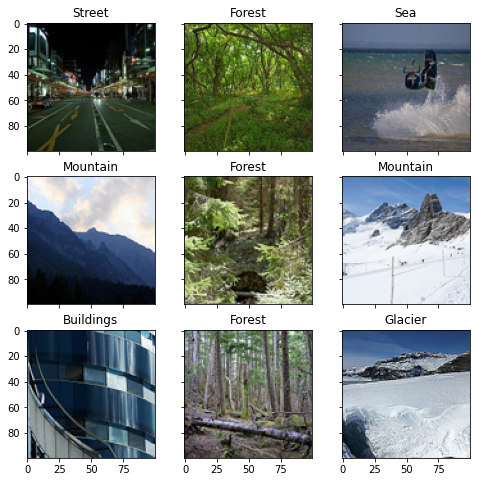

In [64]:
plot_gal(3,3,val_dataset)

# Fit and eval

In [65]:
def fit_epoch(model, train_loader, criterion, optimizer,DEVICE=device):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [67]:
def eval_epoch(model, val_loader, criterion,DEVICE=device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [99]:
def train(train_files, val_files, model, epochs, batch_size,opt):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []

    optim = opt 
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
      print("loss", train_loss)
      print("done",epoch,"epochs")
           
      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))

    return history

In [72]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [73]:
n_classes = len(np.unique(train_val_labels))

In [88]:
resnet_model = models.resnet50(pretrained=True).to(device)

In [77]:
train_dataset = ImageDataset(train_files,mode='train')
print(len(train_dataset))

10525


In [100]:
resnet_history = train(train_dataset,val_dataset,resnet_model,2,256,torch.optim.Adam(model.parameters(),lr=1e-4))

[(11.38142654355518,
  0.0011401425178147269,
  11.341311650182421,
  tensor(0.0020, device='cuda:0', dtype=torch.float64)),
 (11.381426989811333,
  0.0011401425178147269,
  11.341311650182421,
  tensor(0.0020, device='cuda:0', dtype=torch.float64))]